### ** 해석과 판단의 이유를 모두 상세하게 적어주세요 **


In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
warnings.filterwarnings(action = 'ignore')
plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 1.Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [3]:
# Load Data 
data = pd.read_csv("assignment2_data.csv").drop("Unnamed: 0", axis = 1)
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


데이터 탐색과정은 생략하겠음 전처리부터 수행함

#### 데이터 탐색 정리


|변수|dtype|nunique|na|특이사항|
|---|---|---|---|---|
|Name|str|1876|0|unique한 값이 너무 많음, 회사명 + 모델명 구성, 회사명의 nunique 가 31이므로 회사명 추출 + 적당한 기준으로 묶는것이 적절해보임|
|Location|str|11|0|-|
|Year|int|-|0|-|
|Kilobmeters_Driven|int|-|0|-|
|Fuel_Type|str|5|0|Diesel, Petrol의 경우 Mileage의 단위가 전부 kmpl이고 CNG, LPG의 경우 Mileage의 단위가 km/kg, Electric은 na|
|Transmission|str|2|0|-|
|Owner_Type|str|4|0|-|
|Mileage|str|442|2|Fuel_Type이 Electric인 경우 na, 단위가 km/kg, kmpl두개이므로 따로 처리 필요함|
|Engine|str|146|36|Engine이 결측치인 경우 Power, Seats, NewPrice모두 결측, 단위 CC로 통일되어있으므로 단위 제거 작업|
|Power|str|372|36|단위가 bhp로 통일되어있으므로 단위 제거작업, null bhp 함정 숨어있음...|
|Seats|float|-|42|-|
|New_Price|str|540|5195|대부분의 데이터가 결측치, 단위가 2개, 100lakh = 1cr|이므로 lakr으로 통일

* Engine, Poser, Seats의 경우 우선 같은 모델명을 기준으로 채운 후 회사별 평균값으로 대체
* New_Price의 경우 Price의 예측에 영향이 클 것으로 예상되므로 회사별 평균으로 대체

# 2. 데이터 전처리

Price의 왜도 : 3.3352319876668415


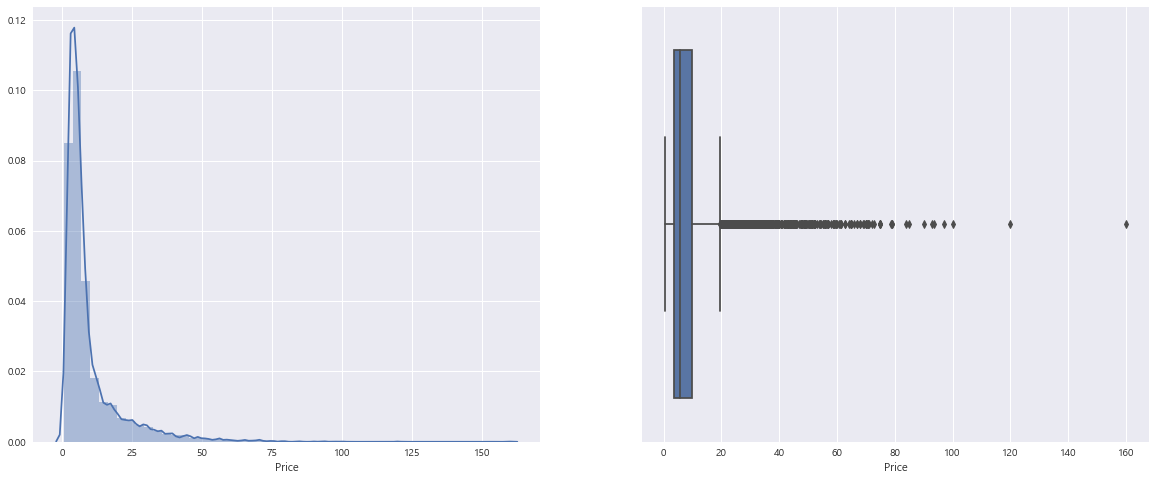

In [4]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.distplot(data.Price)
plt.subplot(1, 2, 2)
sns.boxplot(data.Price)
print("Price의 왜도 :", data.Price.skew())

Price의 왜도 : 0.4173906918413524


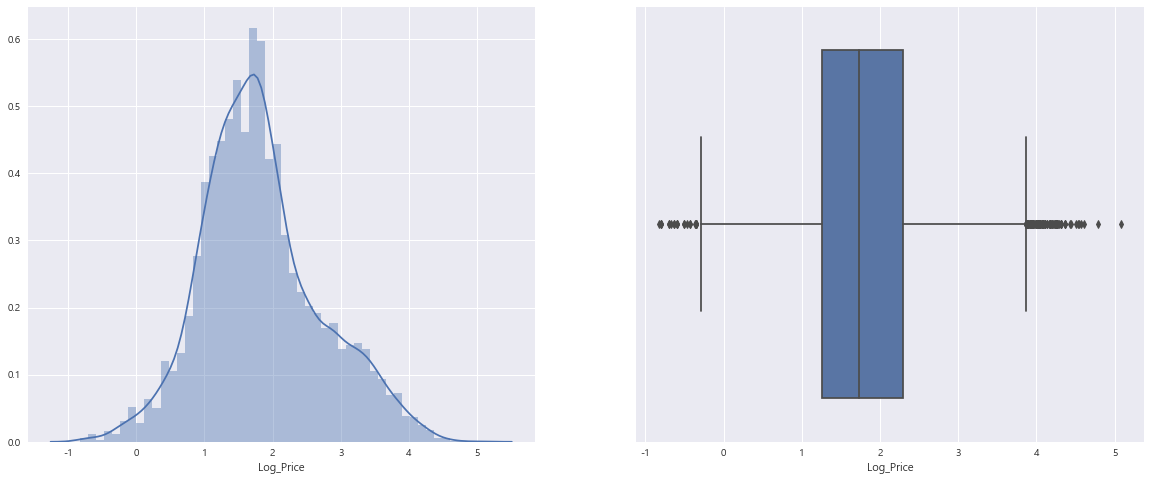

In [5]:
data['Log_Price'] = np.log(data.Price)
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.distplot(data.Log_Price)
plt.subplot(1, 2, 2)
sns.boxplot(data.Log_Price)
print("Price의 왜도 :", data.Log_Price.skew())

target인 Price의 왜도가 너무 크므로 정규성을 확보하기위해 로그변환을 해줌
그 결과 정규분포의 양상을 띄게됨

#### Name
1. Name의 unique한 값이 너무 많으므로 회사명을 추출한다.
2. 회사명은 30개남짓, 이역시 적절한 수는 아닌것으로 판단된다. 
3. 회사별 Log_Price의 평균을 기준으로 회사의 등급을 6개로 나눈다.

In [6]:
data['Company'] = data.Name.apply(lambda x : x.split()[0])

In [7]:
q1 = data.groupby("Company")['Log_Price'].mean().quantile(1/6)
q2 = data.groupby("Company")['Log_Price'].mean().quantile(2/6)
q3 = data.groupby("Company")['Log_Price'].mean().quantile(3/6)
q4 = data.groupby("Company")['Log_Price'].mean().quantile(4/6)
q5 = data.groupby("Company")['Log_Price'].mean().quantile(5/6)
print(q1, q2, q3, q4, q5)

1.1035201746038266 1.587625650676682 2.1744131149754478 2.923532232305731 3.267399302626944


In [8]:
group1 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() < q1].index
group2 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() < q2].index
group3 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() < q3].index
group4 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() < q4].index
group5 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() < q5].index
group6 = data.groupby("Company")['Log_Price'].mean().sort_values()[data.groupby("Company")['Log_Price'].mean().sort_values() >= q5].index

In [9]:
def com_preprocessing(x):
    if x in group1:
        return 'group1'
    elif x in group2:
        return 'group2'
    elif x in group3:
        return 'group3'
    elif x in group4:
        return 'group4'
    elif x in group5:
        return 'group5'
    elif x in group6:
        return 'group6'
data['Com_Group'] = data['Company'].apply(com_preprocessing)

#### Engine, Power, Seats

1. 우선 Engine, Power의 단위를 제거한 뒤 
2. 모델명을 기준으로 Engine, Power, Seats를 최대한 채워준 후 
3. 회사명과 지역을 기준으로 Engine, Power, Seats를 채운다.

In [10]:
def power_preprocessing(x):
    if type(x) == str:
        x = re.sub(" bhp", "", x)
    if x == 'null':
        x = np.nan
    return float(x)

data['Power'] = data.Power.apply(power_preprocessing)
data['Engine'] = data.Engine.apply(lambda x : float(x.split(' ')[0]) if x not in [np.nan] else np.nan)

In [11]:
#모델명 기준
data['Engine'].fillna(data.groupby('Name')['Engine'].transform("mean"), inplace = True)
data['Power'].fillna(data.groupby('Name')['Power'].transform("mean"), inplace = True)
data['Seats'].fillna(data.groupby('Name')['Seats'].transform("mean"), inplace = True)

In [12]:
#회사명, 지역 기준
data['Engine'].fillna(data.groupby(['Company', 'Location'])['Engine'].transform("mean"), inplace = True)
data['Power'].fillna(data.groupby(['Company', 'Location'])['Power'].transform("mean"), inplace = True)
data['Seats'].fillna(data.groupby(['Company', 'Location'])['Seats'].transform("mean"), inplace = True)

In [13]:
data[['Engine', 'Seats', 'Power']].isnull().sum()

Engine    0
Seats     0
Power     1
dtype: int64

In [14]:
data[data.Power.isnull()]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Log_Price,Company,Com_Group
915,Smart Fortwo CDI AT,Pune,2008,103000,Diesel,Automatic,Second,0.0 kmpl,799.0,NaN,2.0,NaN,3.0,1.098612,Smart,group1


In [15]:
#Smart회사의 데이터는 1건이므로 분석 대상에서 제외함
data.drop(915, inplace = True)

#### New_Price

1. 관측치에 대해 단위통일.
2. 모델 기준 fillna
3. 회사와 지역 기준 fillna
4. 회사 기준 fillna
5. 회사group 기준 fillna

In [16]:
def np_preprocessing(x):
    if type(x) == str:
        tmp = x.split()
        if tmp[1] == "Lakh":
            x = float(tmp[0])
        elif tmp[1] == "Cr":
            x = float(tmp[0]) * 100
    return x
data['New_Price'] = data['New_Price'].apply(np_preprocessing)

In [17]:
#모델명 기준
data['New_Price'].fillna(data.groupby('Name')['New_Price'].transform("mean"), inplace = True)

#회사명, 지역 기준
data['New_Price'].fillna(data.groupby(['Company', 'Location'])['New_Price'].transform("mean"), inplace = True)

#회사명 기준
data['New_Price'].fillna(data.groupby('Company')['New_Price'].transform("mean"), inplace = True)

#회사group 기준
data['New_Price'].fillna(data.groupby('Com_Group')['New_Price'].transform("mean"), inplace = True)

#### Mileage

In [18]:
data.query("Fuel_Type == 'Electric'")

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Log_Price,Company,Com_Group
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.58,13.00,2.564949,Mahindra,group3
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,24.33,12.75,2.545531,Toyota,group4


* 마일리지의 단위는 km/l, km/kg로 2개이다. 두 단위를 합리적으로 통합해주기 위한 방법을 찾지 못했다. 하지만 각 단위의 분포가 비슷하고, 둘 다 어느정도 정규성을 띄고 있어서 마일리지의 단위가 km/l, km/kg일때 각각 표준화를 적용해 주었다.
* 표준화 적용 이후 결측치는 Fuel_Type이 Electric인 경우인데 전체 데이터 중 Electric이 2건밖에 없어 전체 마일리지 평균인 0으로 대체한다


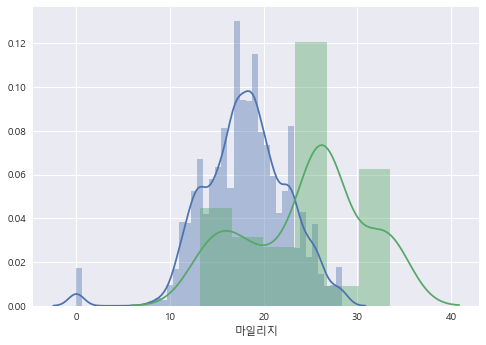

In [19]:
data['단위'] = data.Mileage.apply(lambda x : x.split()[1] if x is not np.nan else np.nan)
data['마일리지'] = data.Mileage.apply(lambda x : float(x.split()[0]) if x is not np.nan else np.nan)

sns.distplot(data.query("단위 == 'kmpl'").마일리지)
sns.distplot(data.query("단위 == 'km/kg'").마일리지)

In [20]:
kmpl_mean = data.query("단위 == 'kmpl'").마일리지.mean()
kmpl_std = data.query("단위 == 'kmpl'").마일리지.std()
kmkg_mean = data.query("단위 == 'km/kg'").마일리지.mean()
kmkg_std = data.query("단위 == 'km/kg'").마일리지.std()

In [21]:
def mileage_preprocessing(x):
    if type(x) == str:
        tmp = x.split()
        if tmp[1] == 'kmpl':
            return (float(tmp[0]) - kmpl_mean) / kmpl_std
        else:
            return (float(tmp[0]) - kmkg_mean) / kmkg_std
    else:
        return np.nan
data['Mileage'] = data['Mileage'].apply(mileage_preprocessing)
data['Mileage'].fillna(0, inplace = True)

### Log변환

Kilometers_Driven, Engine, Power, New_Price변수의 왜도가 너무 크므로 log변환을 통해 정규분포를 띄게 한다.

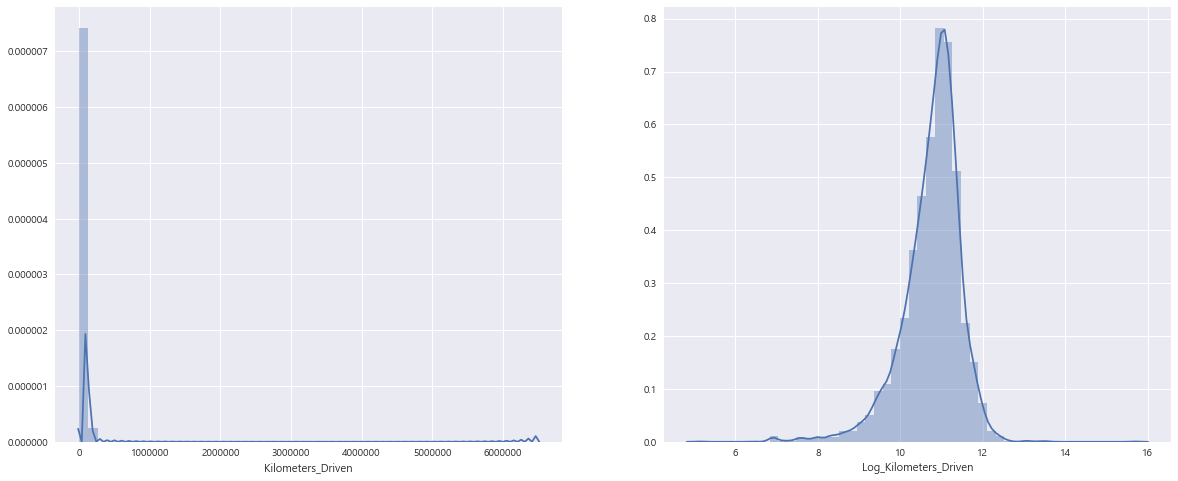

In [22]:
data['Log_Kilometers_Driven'] = np.log(data['Kilometers_Driven'])
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.distplot(data['Kilometers_Driven'])
plt.subplot(1, 2, 2)
sns.distplot(data['Log_Kilometers_Driven'])

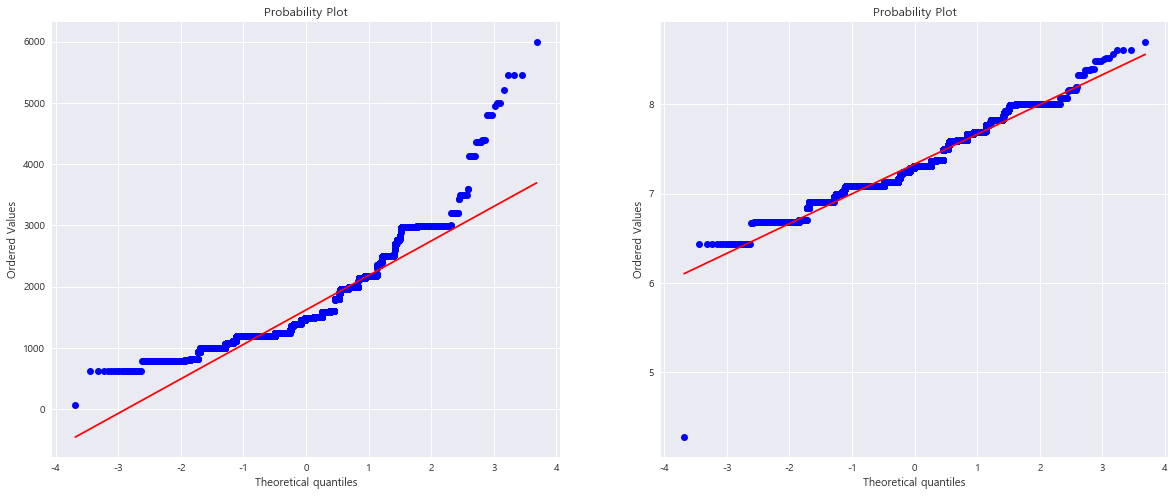

In [23]:
data['Log_Engine'] = np.log(data['Engine'])
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
scipy.stats.probplot(data['Engine'], plot = plt)
plt.subplot(1, 2, 2)
scipy.stats.probplot(data['Log_Engine'], plot = plt)
plt.show()

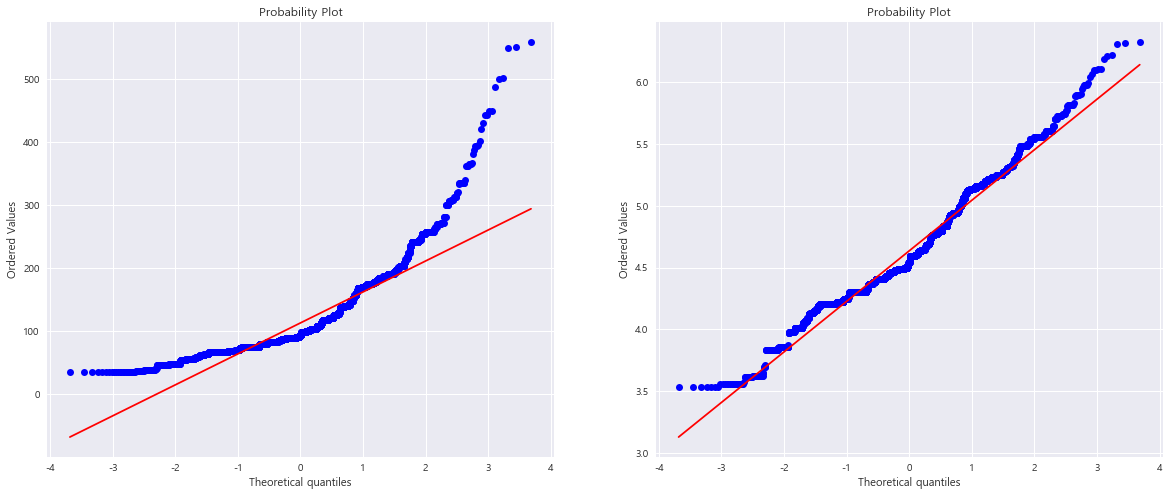

In [24]:
data['Log_Power'] = np.log(data['Power'])
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
scipy.stats.probplot(data['Power'], plot = plt)
plt.subplot(1, 2, 2)
scipy.stats.probplot(data['Log_Power'], plot = plt)
plt.show()

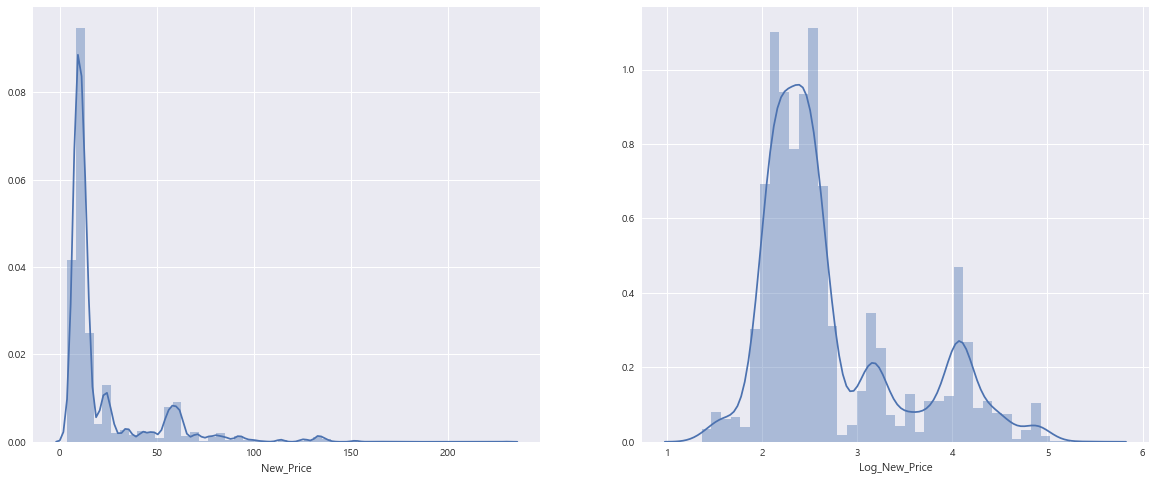

In [25]:
data['Log_New_Price'] = np.log(data['New_Price'])
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.distplot(data['New_Price'])
plt.subplot(1, 2, 2)
sns.distplot(data['Log_New_Price'])

### 데이터 전체

log변환한 numerical 데이터의 경우 변환 전 변수는 버리고, log변환한 변수 채택, 
categorical변수의 경우 Company변수의 nunique가 30이므로 버리고 Log_Price를 기준으로 묶은 Com_Group채택

In [26]:
use_col = ['Location', 'Year', 'Log_Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Log_Engine', 'Log_Power', 'Seats', 'Log_New_Price', 'Com_Group', 'Log_Price']
numerical = ['Year', 'Log_Kilometers_Driven', 'Mileage', 'Log_Engine', 'Log_Power', 'Seats', 'Log_New_Price', 'Log_Price']
categorical = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type','Com_Group']
data = data[use_col].reset_index(drop = 'index')

#### numerical 변수

너무 크거나 작은 단위의 변수의 경우 분석에 지장이 있기 때문에 numerical변수들에 대해 표준화를 해준다

In [27]:
scaler = StandardScaler()
data.loc[:, numerical[:-1]] = scaler.fit_transform(data[numerical[:-1]])

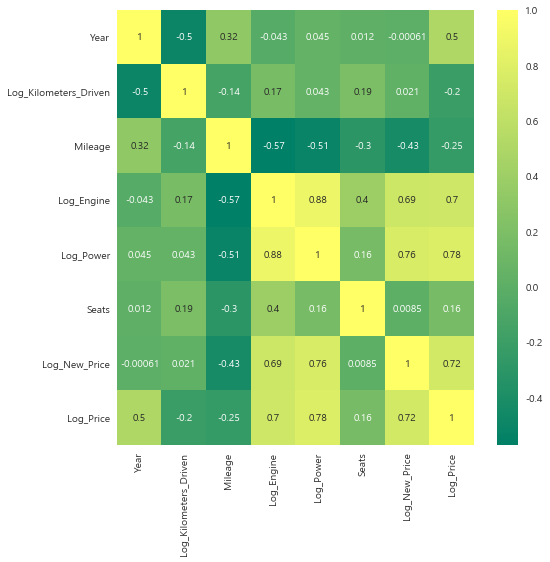

In [28]:
plt.figure(figsize = (8, 8))
sns.heatmap(data[numerical].corr(), annot = True, cmap = 'summer')

* numerical데이터 간 상관계수로 보아 변수들 모두 종속변수인 Log_Price와 어느정도 상관관계가 있어보이므로 선형회귀의 기본 가정인 독립변수와 종속변수간 선형성을 만족한다고 볼 수 있음.
* 하지만 Log_Engine, Log_Power, Log_New_Price변수들이 높은 상관관계를 가지고 있으므로 다중공선성이 우려되므로 numerical 변수들 간 VIF검정 실시

In [29]:
vif_df = pd.DataFrame()
vif_df['variable'] = numerical[:-1]
vif_df['vif_factor'] = [variance_inflation_factor(data[numerical[:-1]].values, i) for i in range(data[numerical[:-1]].shape[1])]
vif_df

,variable,vif_factor
0,Year,1.682013
1,Log_Kilometers_Driven,1.480016
2,Mileage,1.867951
3,Log_Engine,7.168391
4,Log_Power,6.690238
5,Seats,1.675529
6,Log_New_Price,2.544632


VIF결과 다중공선성문제는 크게 있어보이진 않음

#### categorical변수

categorical변수같은 경우 더미변수를 활용하여 인코딩해준다. 

Location같은 경우 Location별 Com_Group의 비중이 상이하여 Price 예측에 영향이 있을것이라 판단하여 포함시켜준다.

In [30]:
cat_df = pd.DataFrame()
for cat in categorical:
    cat_df = pd.concat([cat_df, pd.get_dummies(data[cat], drop_first = True)], axis = 1)

# 회귀분석

데이터에 Intercept column을 만들어 design matrix를 만들어 줌

In [31]:
X = pd.DataFrame(columns = ['Intercept'], data = [1 for _ in range(data.shape[0])])
X = pd.concat([X, data[numerical[:-1]], cat_df], axis = 1)
y = data['Log_Price']

### OLS

후진제거법으로 p-value 0.05를 기준으로 높은 순으로 변수들을 제거해본다

In [32]:
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2747.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 372.05
No. Observations:                6018   AIC:                            -682.1
Df Residuals:                    5987   BIC:                            -474.3
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.47

In [33]:
model = sm.OLS(y, X.drop('LPG', axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2842.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 372.00
No. Observations:                6018   AIC:                            -684.0
Df Residuals:                    5988   BIC:                            -482.9
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.47

In [34]:
model = sm.OLS(y, X.drop(['Fourth & Above', 'LPG'], axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2944.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 371.73
No. Observations:                6018   AIC:                            -685.5
Df Residuals:                    5989   BIC:                            -491.1
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.47

In [35]:
model = sm.OLS(y, X.drop(['Fourth & Above', 'LPG', 'Jaipur'], axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     3052.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 370.76
No. Observations:                6018   AIC:                            -685.5
Df Residuals:                    5990   BIC:                            -497.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.45

In [36]:
model = sm.OLS(y, X.drop(['Fourth & Above', 'LPG', 'Jaipur', 'Kochi'], axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     3169.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 370.05
No. Observations:                6018   AIC:                            -686.1
Df Residuals:                    5991   BIC:                            -505.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.44

In [37]:
model = sm.OLS(y, X.drop(['Fourth & Above', 'LPG', 'Jaipur', 'Kochi', 'Pune'], axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     3295.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 368.38
No. Observations:                6018   AIC:                            -684.8
Df Residuals:                    5992   BIC:                            -510.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.43

In [38]:
model = sm.OLS(y, X.drop(['Fourth & Above', 'LPG', 'Jaipur', 'Kochi', 'Pune', 'Petrol'], axis = 1))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Price   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     3430.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        00:05:05   Log-Likelihood:                 366.60
No. Observations:                6018   AIC:                            -683.2
Df Residuals:                    5993   BIC:                            -515.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.38

후진제거법으로 p-value가 높은 순으로 'Fourth & Above', 'LPG', 'Jaipur', 'Kochi', 'Pune', 'Petrol' 변수들을 제거한 뒤 회귀분석을 진행했다. 
* 분석 결과 adjusted R-Squared이 0.932로 설명력이 좋은편이다.
* F통계량과 p-value를 보았을 때 회귀분석의 귀무가설 (회기식은 유의하지 않다)를 기각, 즉 회귀선은 유의하다.
* 시계열 자료가 아니므로 오차의 독립성은 검증할 필요가 없지만 durbin-watson지수가 1.989로 2에 가까우므로 오차의 자기상관이 없이 독립이라고 할 수 있다.

#### 아직 보이지 않은 회귀분석의 기본 가정
* 정규성
* 등분산성

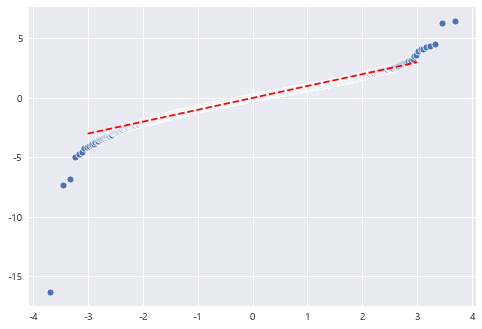

In [39]:
pred = result.predict()
residual = y - pred
sr = scipy.stats.zscore(residual)
(x, y_), _ = scipy.stats.probplot(sr)

sns.scatterplot(x, y_)
plt.plot([-3, 3], [-3, 3], '--', color='red')

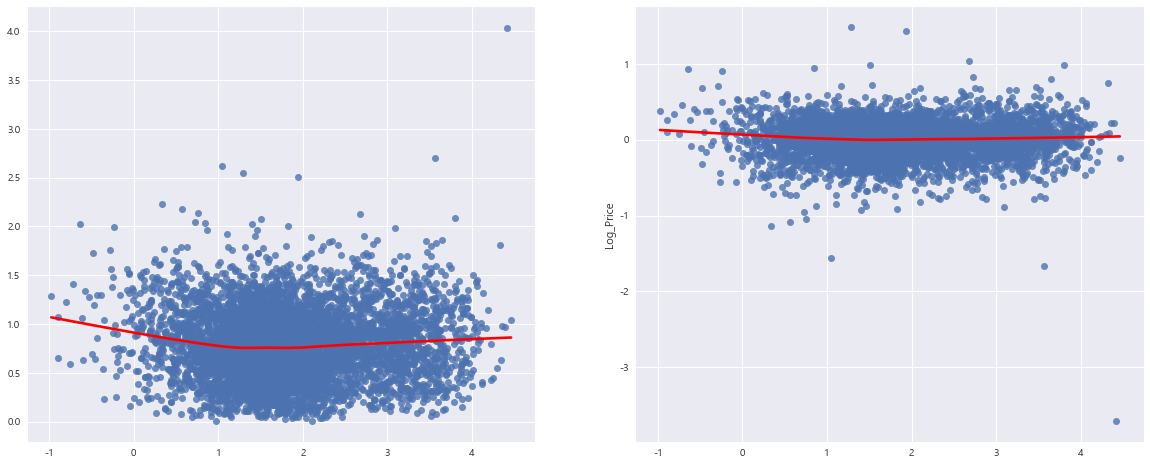

In [40]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
sns.regplot(pred, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})
plt.subplot(1, 2, 2)
sns.regplot(pred, residual, lowess=True, line_kws={'color': 'red'})

qq-plot의 결과로 어느정도 점들이 선에 잘 모여있는 것을 보아 정규성 가정을 어느정도 만족한다고 볼 수 있음

regplot의 결과 빨간선이 완벽하게 직선은 아님, 하지만 잔차의 산점도로 보았을때 일정하게 퍼져있는것을 보아 등분산성 가정도 어느정도 만족한다고 볼 수 있음

### sklearn

위에서 후진제거법으로 얻은 독립변수로 회귀분석 진행

In [41]:
X.drop(['Fourth & Above', 'LPG', 'Jaipur', 'Kochi', 'Pune', 'Petrol', 'Intercept'], axis = 1, inplace = True)

#### LinearRegression

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
lr.coef_

array([ 0.37291854, -0.05063208, -0.01322232,  0.10050852,  0.30768143,
        0.03119067,  0.07337785,  0.17597165,  0.05572455,  0.13708366,
       -0.0422527 ,  0.15821727, -0.19800182, -0.03095478,  0.17682848,
        1.09740276, -0.11217175, -0.07011391, -0.13286203,  0.35163473,
        0.28293244,  0.52133501,  0.80869723,  1.04247563])

In [45]:
lr.intercept_

1.3935166795322012

In [46]:
#trainset의 r2_score과 mse
pred = lr.predict(X_train)
print("훈련집합\nr2_score :", r2_score(y_train, pred), 'mse :', mean_squared_error(y_train, pred))

훈련집합
r2_score : 0.9347066780086787 mse : 0.050168410062185274


In [47]:
#testset의 r2_score과 mse
pred = lr.predict(X_test)
print("테스트집합\nr2_score :", r2_score(y_test, pred), 'mse :', mean_squared_error(y_test, pred))

테스트집합
r2_score : 0.9203654853207712 mse : 0.059409477493496586


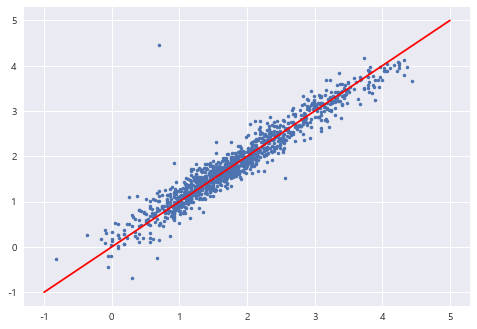

In [48]:
x_ = np.linspace(-1, 5, 100)
y_ = x_
plt.plot(y_test, pred, '.')
plt.plot(x_, y_, c = 'r')

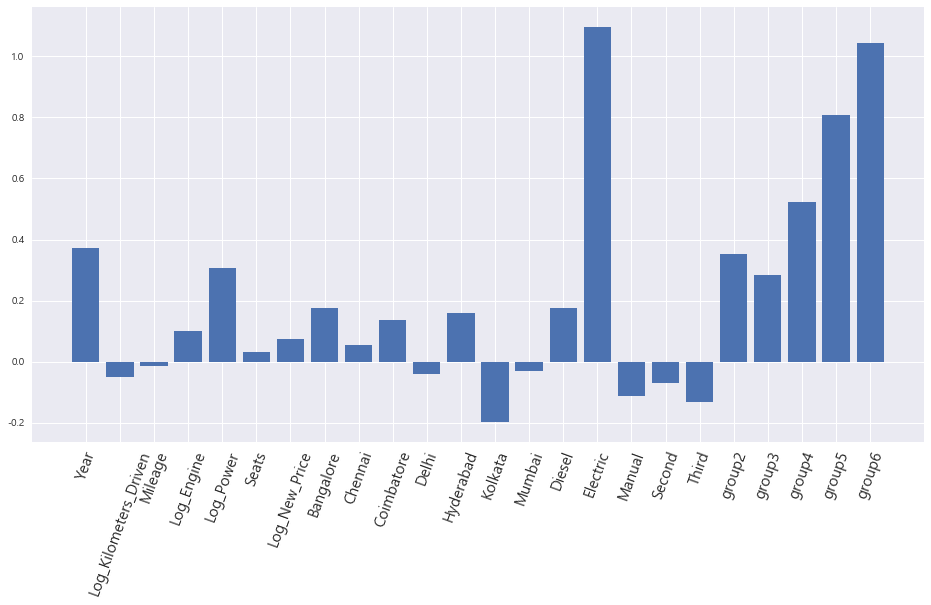

In [49]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, lr.coef_)
plt.xticks(rotation = 70, fontsize = 15)
plt.show()

* 회귀계수 측면에서 상수항, 독립변수의 회귀계수가 ols로 도출한 회귀계수와 일치하는 것을 확인
* R-square, MSE로 성능을 측정해보았을 때 훈련집합 뿐만 아니라 테스트집합에 대해서도 아주 잘 예측하는것을 볼 있음
* 직선상에서 크게 벗어난 점이 몇개 없는걸로 보아 꽤 유의한 선형회귀 결과임

#### Lasso

cv를 통해 최적의 alpha값을 찾고 LinearRegression에서의 coefficient와 비교한다

In [50]:
params = {'alpha' : [10, 5, 1, 0.5, 0.1, 0.05, 0.01],
         'max_iter' : [100000],
         'tol' : [0.0001, 0.00001, 0.000001]}
lasso = Lasso()
grid = GridSearchCV(lasso, params, scoring = 'r2', cv = 4, n_jobs = -1, verbose = 1)
grid.fit(X, y)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  77 out of  84 | elapsed:    5.4s remaining:    0.4s


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
0.9047993393673063


[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    5.4s finished


In [51]:
lasso = Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
              normalize=False, positive=False, precompute=False, random_state=None,
              selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [52]:
lasso.coef_

array([ 0.39622907, -0.02888738, -0.        ,  0.101843  ,  0.32529649,
        0.02351575,  0.26740807,  0.        ,  0.        ,  0.00650718,
       -0.        ,  0.07166037, -0.07308751, -0.        ,  0.1130202 ,
        0.        , -0.07864834, -0.        , -0.        ,  0.01710134,
       -0.01715945,  0.        ,  0.00301797,  0.        ])

In [53]:
lasso.intercept_

1.8153109651693058

In [54]:
#trainset의 r2_score과 mse
pred = lasso.predict(X_train)
print("훈련집합\nr2_score :", r2_score(y_train, pred), 'mse :', mean_squared_error(y_train, pred))

훈련집합
r2_score : 0.9102848924855595 mse : 0.06893299598319923


In [55]:
#testset의 r2_score과 mse
pred = lasso.predict(X_test)
print("테스트집합\nr2_score :", r2_score(y_test, pred), 'mse :', mean_squared_error(y_test, pred))

테스트집합
r2_score : 0.8904599842916139 mse : 0.08171978097785842


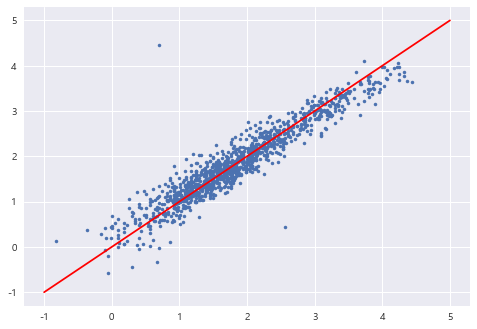

In [56]:
x_ = np.linspace(-1, 5, 100)
y_ = x_
plt.plot(y_test, pred, '.')
plt.plot(x_, y_, c = 'r')

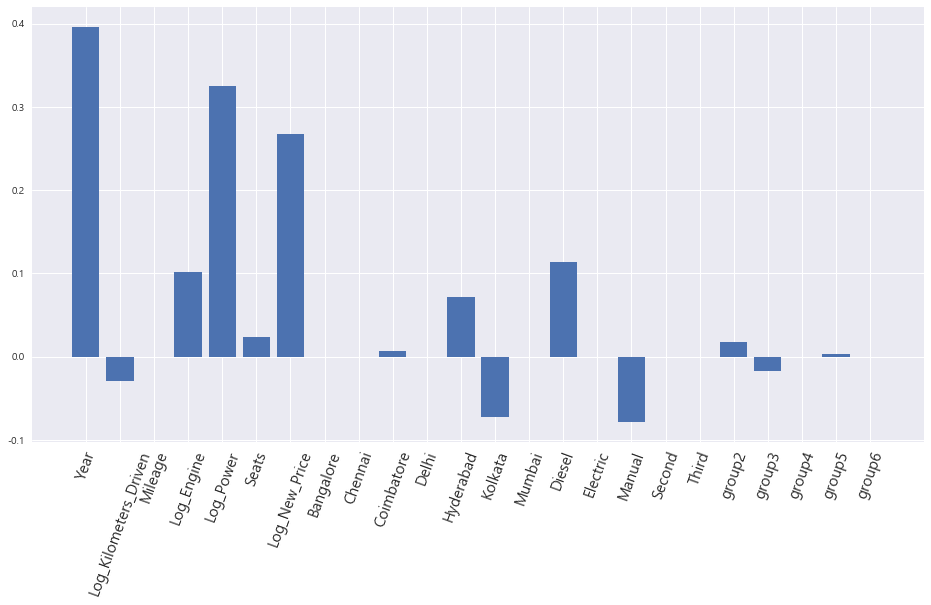

In [57]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, lasso.coef_)
plt.xticks(rotation = 70, fontsize = 15)
plt.show()

* lasso회귀는 L1 정규화를 사용하는 회귀이다. $\alpha$값이 높을수록 규제가 강하게 되어 회귀계수의 크기가 줄게된다.
* lasso회귀를 진행한 결과 회귀계수중 다수가 0으로 수렴했다. 또한 기존 LinearRegression의 coefficient와 비교해보면 LinearRegression에서는 연속형 변수의 회귀계수가 작은 편이었는데 lasso의 경우 범주형변수의 회귀계수가 대부분 0으로 수렴하거나 작아졌다.
* $\alpha$값 0.001을 적용한 결과 LinearRegression보다 훈련집합과 테스트집합 모두에서 성능이 떨어졌다. 더 작은 $\alpha$값 즉, 규제를 덜 해야 더 나은 성능을 기대할 수 있을것같다.

#### Ridge

cv를 통해 최적의 alpha값을 찾고 LinearRegression에서의 coefficient와 비교한다

In [58]:
params = {'alpha' : [10, 5, 1, 0.5, 0.1, 0.05, 0.01],
         'max_iter' : [100000],
         'tol' : [0.0001, 0.00001, 0.000001]}
ridge = Ridge()
grid = GridSearchCV(ridge, params, scoring = 'r2', cv = 4, n_jobs = -1, verbose = 1)
grid.fit(X, y)
print(grid.best_estimator_)
print(grid.best_score_)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='auto', tol=0.0001)
0.9302018558397578


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    0.8s finished


In [59]:
ridge = Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100000,
              normalize=False, random_state=None, solver='auto', tol=0.0001)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='auto', tol=0.0001)

In [60]:
ridge.coef_

array([ 0.3729026 , -0.05066228, -0.01313337,  0.10080206,  0.30745113,
        0.03117536,  0.07414945,  0.17576543,  0.05561261,  0.13698526,
       -0.04221625,  0.1581717 , -0.19791894, -0.03084925,  0.17668631,
        0.9968662 , -0.11245974, -0.07015091, -0.13275136,  0.35042918,
        0.28142181,  0.51928415,  0.80538305,  1.03780559])

In [61]:
ridge.intercept_

1.3954706559825851

In [62]:
#trainset의 r2_score과 mse
pred = ridge.predict(X_train)
print("훈련집합\nr2_score :", r2_score(y_train, pred), 'mse :', mean_squared_error(y_train, pred))

훈련집합
r2_score : 0.9347037114418045 mse : 0.050170689436842324


In [63]:
#testset의 r2_score과 mse
pred = ridge.predict(X_test)
print("테스트집합\nr2_score :", r2_score(y_test, pred), 'mse :', mean_squared_error(y_test, pred))

테스트집합
r2_score : 0.9201112328031318 mse : 0.05959915667073786


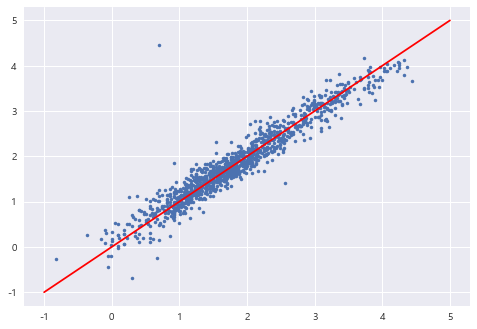

In [64]:
x_ = np.linspace(-1, 5, 100)
y_ = x_
plt.plot(y_test, pred, '.')
plt.plot(x_, y_, c = 'r')

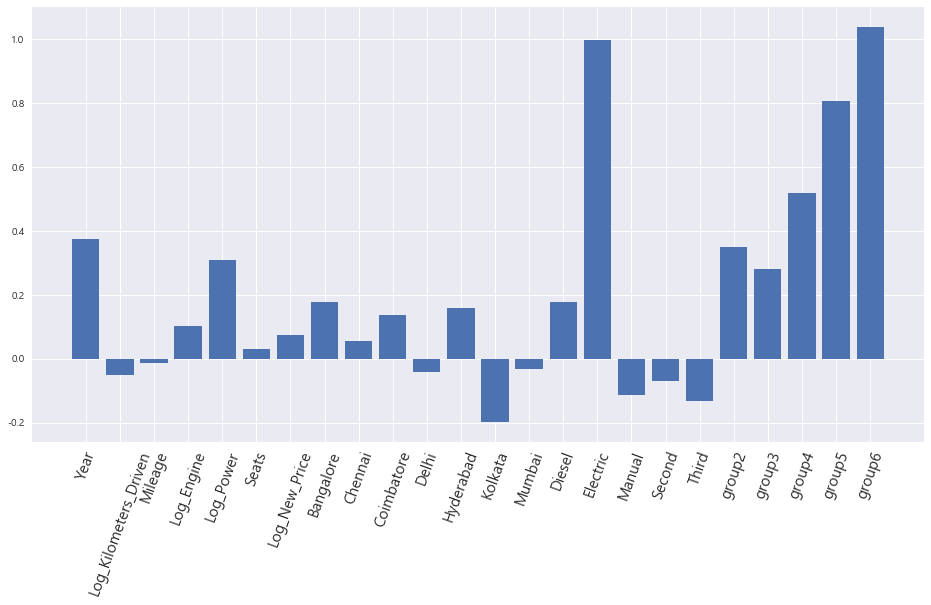

In [65]:
plt.figure(figsize = (16, 8))
plt.bar(X.columns, ridge.coef_)
plt.xticks(rotation = 70, fontsize = 15)
plt.show()

* ridge회귀는 L2 정규화를 사용하는 회귀이다. $\alpha$값이 높을수록 규제가 강하게 되어 회귀계수의 크기가 줄게된다.
* ridge회귀를 진행한 결과 $\alpha$값 0.1을 사용하여 lasso회귀때보다 더 큰 규제를 했음에도 LinearRegression과 회귀계수의 차이가 거의 없고 성능또한 훈련집합, 테스트집합 모두에서 차이가 거의 없다.